# Analyzing Training, Validation, and Testing Sets
Plotting some distributions of the test set.

In [1]:
import sys
import os
import time
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
#from watchmal.testing.repeating_classifier_training_utils import *
from functools import reduce

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)

sys.path.append("../..")
sys.path.append("..")

from short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import *

%load_ext autoreload
%matplotlib inline
%autoreload 2

from IPython.display import HTML

In [2]:
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Process, Pool
import boost_histogram as bh

## Load Data

In [3]:
# Import test events from h5 file
original_data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_oldreflector_e-mu-gamma_E0to1000MeV_truehits.h5"

#original_data_path = '/fast_scratch/WatChMaL/data/test_truehits.h5'
data_file = h5py.File(original_data_path, "r")

print(data_file.keys())

hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
#hdf5_hit_charge = data_file["hit_charge"]
#exp_data = ExploratoryDataset(original_data_path)

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_parent', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


In [4]:
hit_pmt    = np.memmap(original_data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(original_data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)
"""
hit_charge = np.memmap(original_data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)
"""

'\nhit_charge = np.memmap(original_data_path, mode="r", shape=hdf5_hit_charge.shape,\n                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)\n'

In [5]:
angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

#original_radius = [np.sqrt(original_positions[i,0,0]**2 + original_positions[i,0,2]**2) for i in range(original_positions.shape[0])]


In [17]:
"""
train_g_idxs = np.array(range(6000, 9000))
train_e_idxs = np.array(range(3000))
train_m_idxs = np.array(range(3000, 6000))
"""

In [19]:
"""
print(labels[train_g_idxs])
print(labels[train_e_idxs])
print(labels[train_m_idxs])
"""

[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[2 2 2 ... 2 2 2]


# Initialize Event Parameters

In [6]:
barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
pmts_per_mpmt = 19

event_hits_index = np.append(data_file["event_hits_index"], hdf5_hit_pmt.shape[0]).astype(np.int64)

mpmt_positions_file = '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz'
mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

data_size = np.max(mpmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt
data_size = np.insert(data_size, 0, n_channels)

In [7]:
item = 0 #val_idxs[i]

start = event_hits_index[item]
stop  = event_hits_index[item + 1]

time = hit_time[start:stop]

# Test making hists

In [7]:
def get_large_times_hist(pos, indices, bins, name):
    #TODO: Until tqdm in the docker image is updated, this print statement appears to be required
    print('')
    pmt_charge = []
    description = '{} Progress: '.format(name)
    
    hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1]))#, growth=True))
    for i in tqdm(indices, desc=description, position=pos):
        item = i
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        hit_data = hit_time[start:stop]

        hist.fill(hit_data)

    return hist.to_numpy()

In [8]:
def get_large_times_hists(input_sets, bins, names):
    pool = Pool(len(input_sets))
    arg_list = [(idx, item, bins, name) for idx, (item, name) in enumerate(zip(input_sets, names))]
    result_hists, result_bins = zip(*pool.starmap(get_large_times_hist, arg_list))
    return result_hists, result_bins

In [9]:
def get_event_hit_times(indices):
    pmt_times = []
    pbar = ProgressBar(widgets=['Calculating PMT Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
               ' ', ETA()], maxval=len(indices))

    pbar.start()
    for idx, i in enumerate(indices):
        pbar.update(idx)

        item = i #val_idxs[i]
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        times  = hit_time[start:stop]
        #print(charge)
        pmt_times.extend(times)
        #print(pmt_charge[0])
        #input()
    pbar.finish()

    #dataset_info[1]['pmt_charge'] = np.array(pmt_charge)
    return np.array(pmt_times)

## Split Datasets

In [10]:
idxs_path = '/home/jtindall/WatChMaL_analysis/short_tank_exploratory_data_analysis/new_dataset/new_dataset_data/equal_indices_all_events.npz'

idxs = np.load(idxs_path, allow_pickle=True)

train_idxs = idxs['train_idxs']
val_idxs   = idxs['val_idxs']
test_idxs  = idxs['test_idxs']

In [11]:
train_angles    = angles[train_idxs]
train_energies  = energies[train_idxs]
train_positions = positions[train_idxs]
train_labels    = labels[train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 
              'angles':train_angles, 'labels':train_labels}

print("Done train info")

val_angles     = angles[val_idxs]
val_energies   = energies[val_idxs]
val_positions  = positions[val_idxs]
val_labels     = labels[val_idxs]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 
            'angles':val_angles, 'labels':val_labels}

print("Done val info")

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]
test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 
             'angles':test_angles, 'labels':test_labels}

print("Done test info")


Done train info
Done val info
Done test info


In [7]:
"""
train_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]
val_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]
test_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]

np.savez('./new_dataset_data/event_radii.npz', train_radii=train_info['radius'], val_radii=val_info['radius'], test_radii=test_info['radius'])
"""

"\ntrain_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]\nval_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]\ntest_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]\n\nnp.savez('./new_dataset_data/event_radii.npz', train_radii=train_info['radius'], val_radii=val_info['radius'], test_radii=test_info['radius'])\n"

In [8]:
f = np.load('./new_dataset_data/event_radii.npz', allow_pickle=True)

train_info['radius'] = f['train_radii']
val_info['radius']   = f['val_radii']
test_info['radius']  = f['test_radii']

In [12]:
dataset_info = [train_info,val_info,test_info]

# Specific Indexes

In [13]:
# Get dataset idxs by particle type
train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs   = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs  = np.where(dataset_info[2]['labels']==1)[0]

train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs   = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs  = np.where(dataset_info[2]['labels']==0)[0]

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

# Sample Hit Times

In [14]:
bins = np.linspace(-50, 100, 100)

In [15]:
# Get hist data for full dataset
time_large_plot_inputs = [train_g_idxs, val_g_idxs, test_g_idxs,
                     train_e_idxs, val_e_idxs, test_e_idxs,
                     train_m_idxs, val_m_idxs, test_m_idxs,]

time_large_plot_names = ['train_g', 'val_g', 'test_g',
                    'train_e', 'val_e', 'test_e',
                    'train_m', 'val_m', 'test_m']

In [27]:
# Get data
bins = np.linspace(100, 140, 40)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, bins, time_large_plot_names)

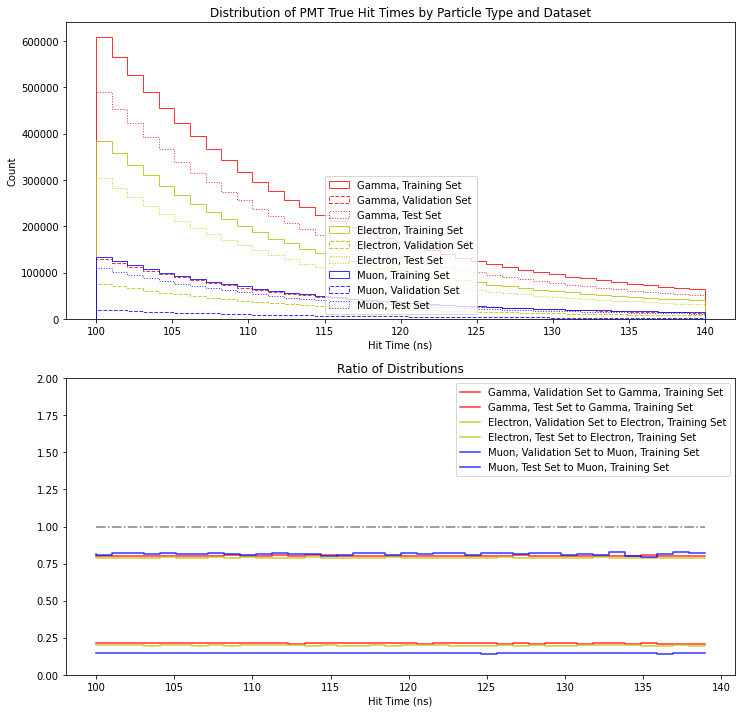

In [28]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT True Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Time (ns)',
                    normalized=False,
                    yscale='linear',
                    loc='lower center'
                   )

In [16]:
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, bins, time_large_plot_names)

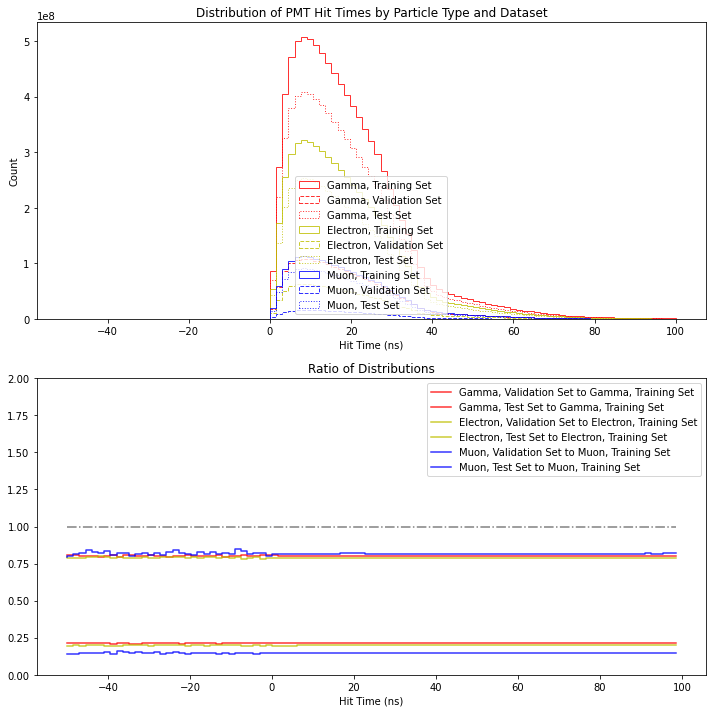

In [17]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Time (ns)',
                    normalized=False,
                    yscale='linear',
                    loc='top right'
                   )

In [20]:
# Get data
bins = np.linspace(0, 40, 40)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, bins, time_large_plot_names)

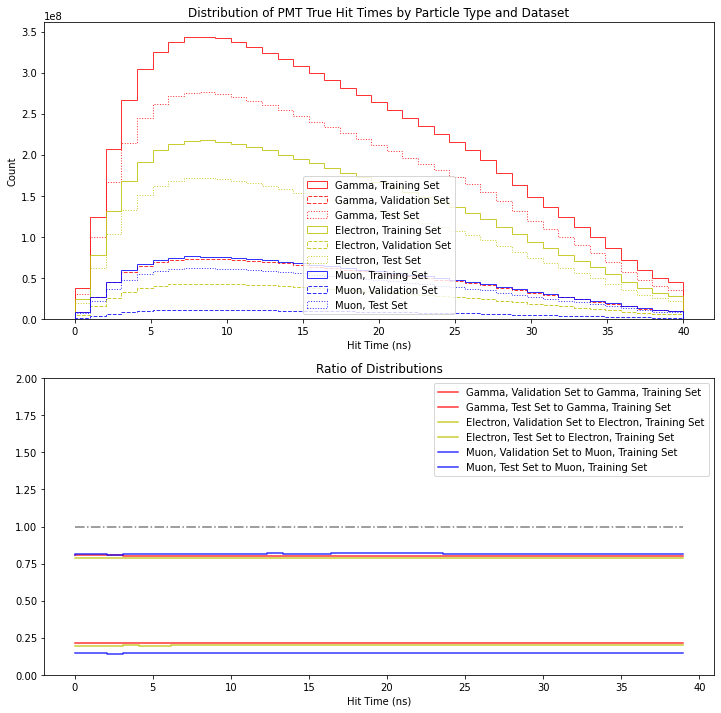

In [22]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT True Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Time (ns)',
                    normalized=False,
                    yscale='linear',
                    loc='lower center'
                   )

In [31]:
# Get data
bins = np.linspace(0, 40, 80)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, bins, time_large_plot_names)

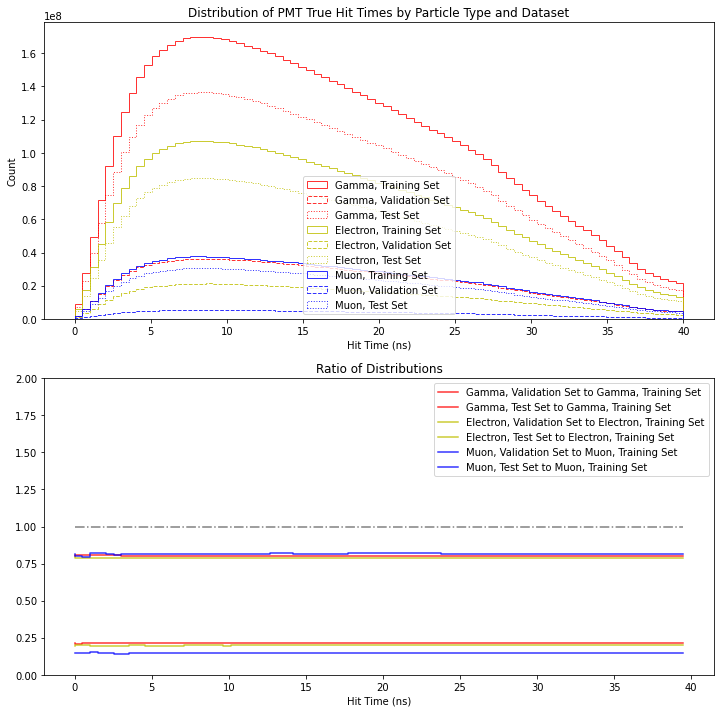

In [32]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT True Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Time (ns)',
                    normalized=False,
                    yscale='linear',
                    loc='lower center'
                   )

In [33]:
# Get data
bins = np.linspace(0, 40, 3*40)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, bins, time_large_plot_names)

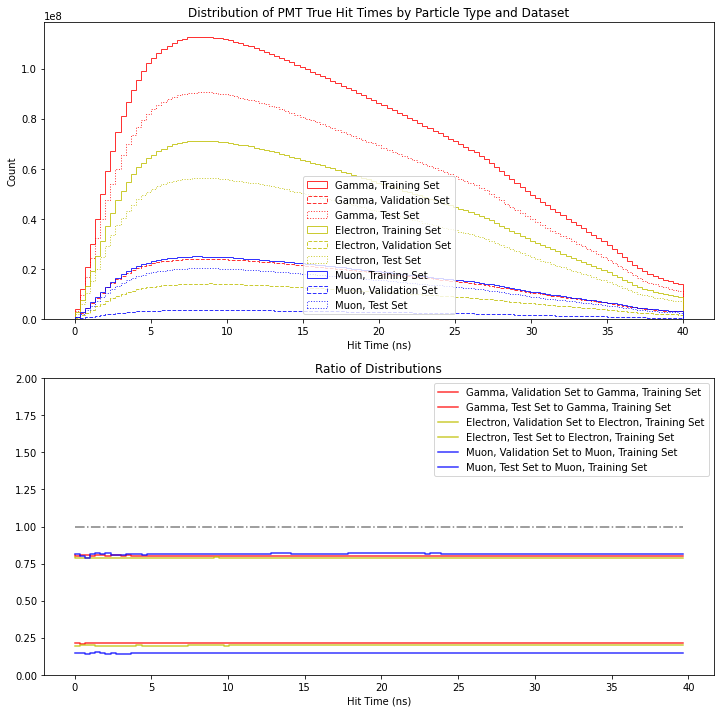

In [34]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT True Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Time (ns)',
                    normalized=False,
                    yscale='linear',
                    loc='lower center'
                   )

In [35]:
# Get data
bins = np.linspace(0, 40, 5*40)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, bins, time_large_plot_names)

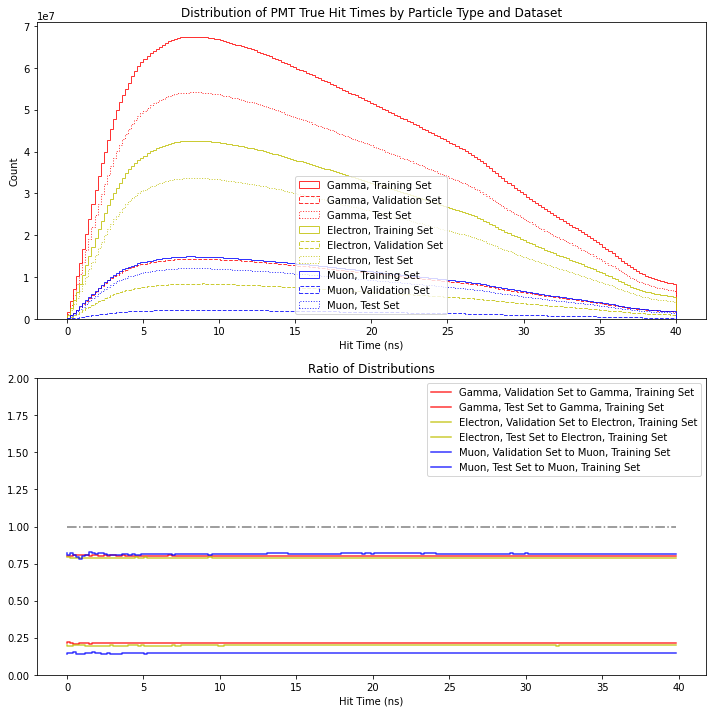

In [36]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT True Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Time (ns)',
                    normalized=False,
                    yscale='linear',
                    loc='lower center'
                   )

In [29]:
# Get data
bins = np.linspace(0, 40, 1000)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, bins, time_large_plot_names)

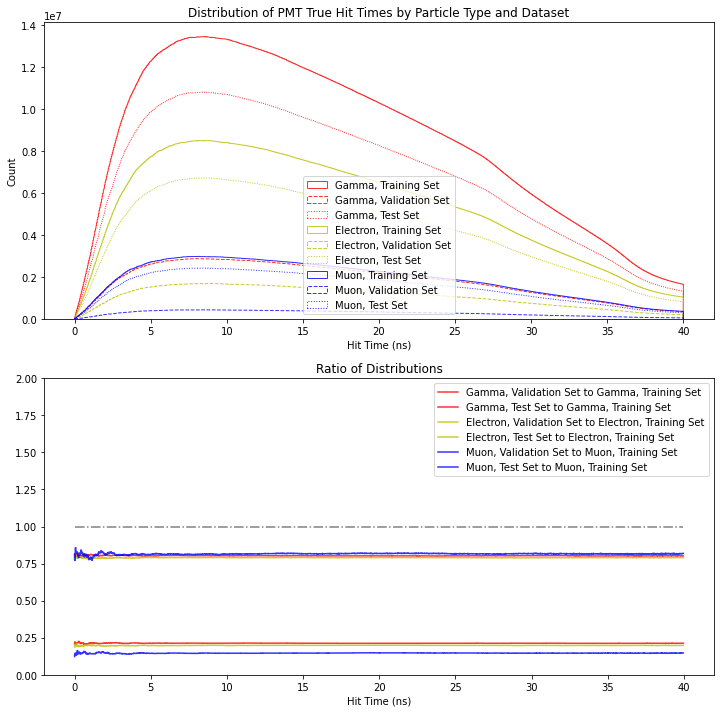

In [30]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT True Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Time (ns)',
                    normalized=False,
                    yscale='linear',
                    loc='lower center'
                   )

In [47]:
# Get hist data for full dataset
middle_time_bins = np.linspace(15, 20, 100)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, middle_time_bins, time_large_plot_names)

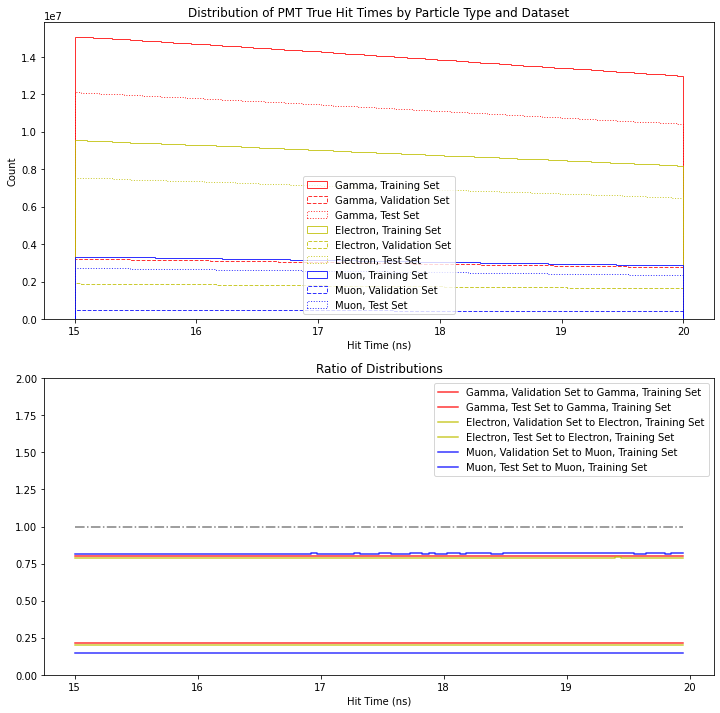

In [48]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT True Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Time (ns)',
                    normalized=False,
                    yscale='linear',
                    loc='lower center'
                   )

In [54]:
# Get hist data for full dataset
middle_time_bins = np.linspace(15, 20, 200)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, middle_time_bins, time_large_plot_names)

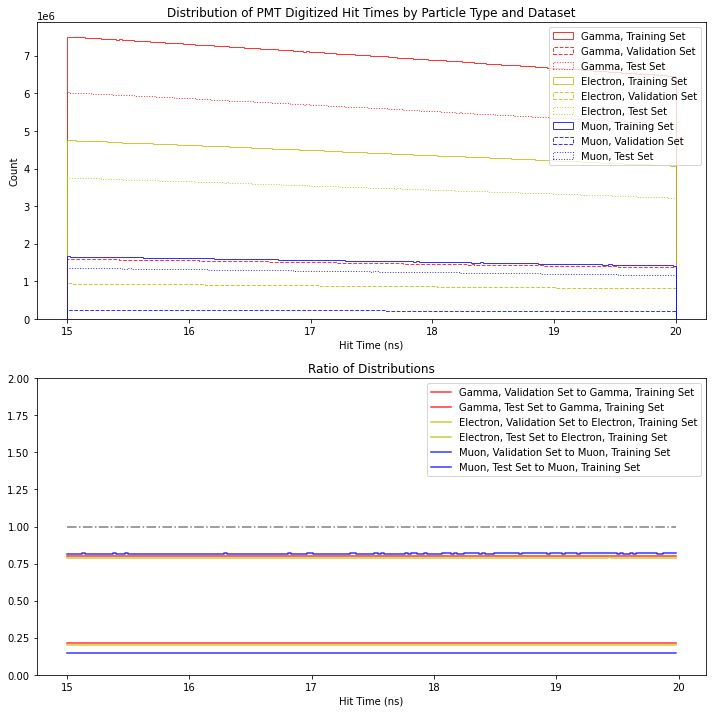

In [55]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Digitized Hit Times by Particle Type and Dataset', 
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'],
                    normalized=False,
                    yscale='linear',                    
                    xlabel='Hit Time (ns)'
                   )

# Event Plotting

In [51]:
event_names   = ['Event']
event_indices = [np.array([0])]

In [58]:
event_bins = np.linspace(0, 40, 41)
time_hists, time_bins = get_large_times_hists(event_indices, event_bins, event_names)

No handles with labels found to put in legend.


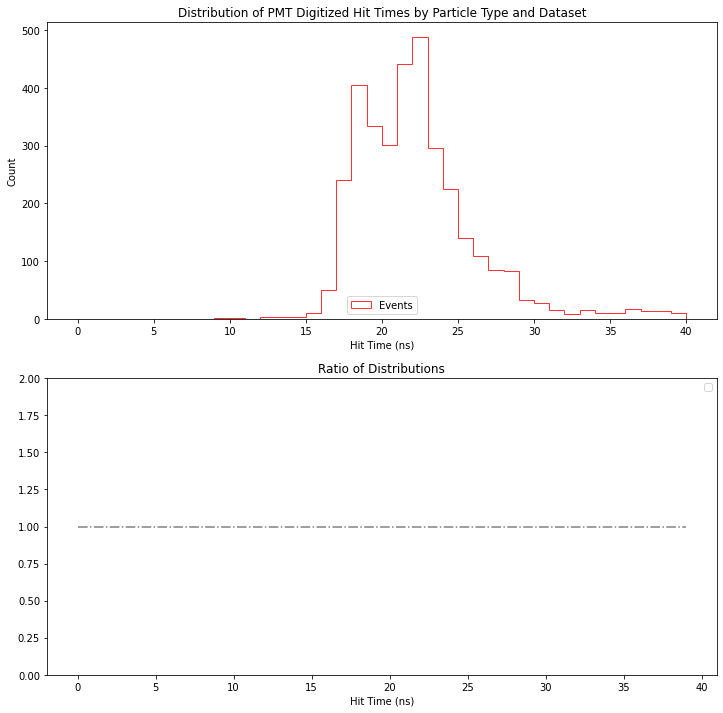

In [59]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=['Events'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Digitized Hit Times by Particle Type and Dataset', 
                    colors   = ['r'],
                    linestyle=['-'],
                    normalized=False,
                    yscale='linear',                    
                    xlabel='Hit Time (ns)',
                    loc='lower center'
                   )

In [62]:
event_bins = np.linspace(15, 20, 100)
time_hists, time_bins = get_large_times_hists(event_indices, event_bins, event_names)

No handles with labels found to put in legend.


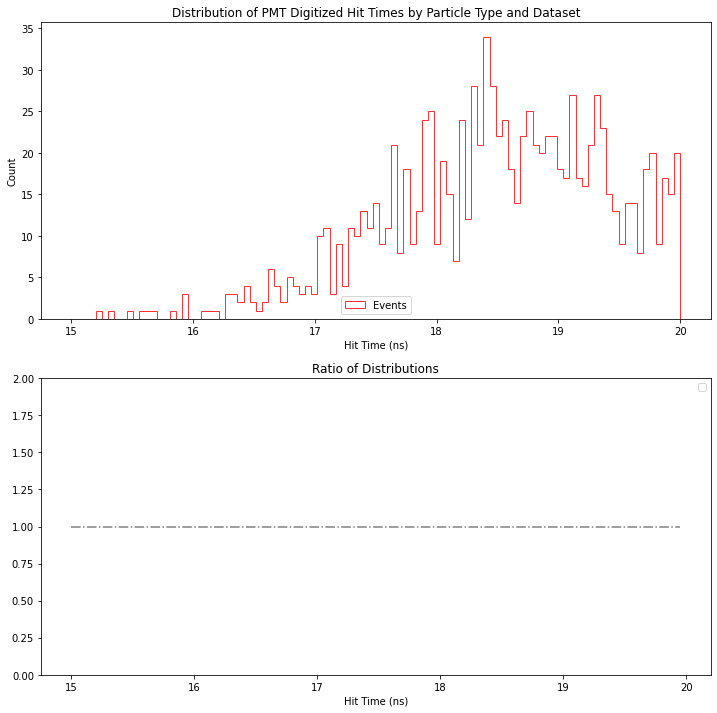

In [63]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=['Events'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Digitized Hit Times by Particle Type and Dataset', 
                    colors   = ['r'],
                    linestyle=['-'],
                    normalized=False,
                    yscale='linear',                    
                    xlabel='Hit Time (ns)',
                    loc='lower center'
                   )